# Ames House数据集上的回归分析

Ames房价预测是Kaggle平台上的一个竞赛任务，需要根据房屋的特征来预测亚美尼亚州洛瓦市（Ames，Lowa）的房价。其中房屋的特征x共有79维，响应值y为每个房屋的销售价格（SalePrice）。

Kaggle官网上的任务说明请见：
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

由于房屋的属性较多，且房屋属性类型各异，所以先对原数据集进行特征编码。特征工程过程请见FE_AmesHouse.ipynb


本代码直接在编码后的数据集上进行线性回归及其各种正则算法进行验证。

Kaggle平台上kernel区有各个竞赛参数者分享的代码，大家可以学习。
下面的代码也参考了很多不同选手分享的代码，在此一并致谢。

In [1]:
# 导入必要的工具包
# 数据读取及基本处理
import pandas as pd
import numpy as np

#模型选择／参数调优
from sklearn.model_selection import cross_val_score, train_test_split

#模型
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

#模型评估
from sklearn.metrics import mean_squared_error, make_scorer

#可视化
import matplotlib.pyplot as plt

In [2]:
# 读入数据
train = pd.read_csv("AmesHouse_FE_train.csv")
print("train : " + str(train.shape))

test = pd.read_csv("AmesHouse_FE_test.csv")
print("test : " + str(test.shape))

train : (1456, 344)
test : (1459, 344)


**准备训练数据**

In [3]:
y_train = train["SalePrice"]
X_train = train.drop(['SalePrice'], axis = 1)
test_Id = test['Id']
X_test = test.drop(['Id'], axis = 1)

In [4]:
# 数据标准化
from sklearn.preprocessing import StandardScaler

# 初始化对目标值的标准化器
ss_y = StandardScaler()

mean_y = y_train.mean()
std_y = y_train.std()
y_train = (y_train - mean_y)/std_y
#y_train = ss_y.fit_transform(y_train.values.reshape(-1, 1))
#y_test = ss_y.transform(y_test.reshape(-1, 1))

**1* Linear Regression without regularization**

In [5]:
# Linear Regression
lr = LinearRegression()

#rmse_train_cv = cross_val_score(model, X_train, y_train, scoring = 'neg_mean_squared_error', cv = 10)
#rmse_train_cv = rmse_cv(lr, X_train, y_train)
#print("RMSE on Training set by CV-10 :", rmse_train_cv.mean())

lr.fit(X_train, y_train)

# Look at predictions on training and validation set
y_train_pred = lr.predict(X_train)
#y_test_pred = lr.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train,y_train_pred))
#rmse_test = np.sqrt(mean_squared_error(y_test,y_test_pred))

print("RMSE on Training set :", rmse_train)
#print("RMSE on Test set :", rmse_test)

('RMSE on Training set :', 0.24853506074754278)


In [6]:
# 线性模型，随机梯度下降优化模型参数
from sklearn.linear_model import SGDRegressor

# 使用默认配置初始化线
sgdr = SGDRegressor(max_iter = 5000)

# 训练：参数估计
sgdr.fit(X_train, y_train)
y_train_pred = sgdr.predict(X_train)
#y_test_pred = sgdr.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train,y_train_pred))
#rmse_test = np.sqrt(mean_squared_error(y_test,y_test_pred))

print("RMSE on Training set :", rmse_train)

('RMSE on Training set :', 0.25757999586318286)


**2* Linear Regression with Ridge regularization (L2 penalty)**

In [7]:
# 2* Ridge
#RidgeCV缺省的score是mean squared errors (by default)
ridge = RidgeCV(alphas = [0.01, 0.1, 1, 10, 100, 1000],store_cv_values=True )
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

mse_cv = np.mean(ridge.cv_values_, axis = 0)
rmse_cv = np.sqrt(mse_cv)
print("cv of rmse :", min(rmse_cv))

y_train_rdg = ridge.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train,y_train_rdg))
print("RMSE on Training set :", rmse_train)

('Best alpha :', 10.0)
('cv of rmse :', 0.31897021511259349)
('RMSE on Training set :', 0.26825283183497006)


Try again for more precision with alphas centered around 10.0
('Best alpha :', 12.5)
('cv of rmse :', 0.31891891935221395)
('RMSE on Training set :', 0.27004042322630895)
Ridge picked 297 features and eliminated the other 46 features


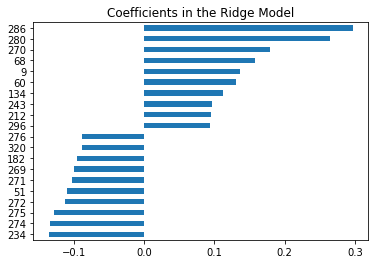

In [8]:
print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                store_cv_values=True)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

mse_cv = np.mean(ridge.cv_values_, axis = 0)
rmse_cv = np.sqrt(mse_cv)
print("cv of rmse :", min(rmse_cv))

y_train_rdg = ridge.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train,y_train_rdg))
print("RMSE on Training set :", rmse_train)


# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

**3* Linear Regression with Lasso regularization (L1 penalty)**

/Users/qing/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


('Best alpha :', 0.001)
Try again for more precision with alphas centered around 0.001
('Best alpha :', 0.0010500000000000002)
('cv of rmse :', 0.31891891935221395)
('RMSE on Training set :', 0.27004042322630895)
Lasso picked 129 features and eliminated the other 214 features


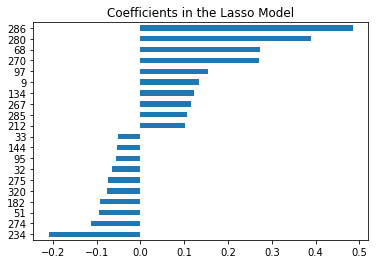

In [9]:
# 3* Lasso
lasso = LassoCV(alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
                max_iter = 5000)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

mse_cv = np.mean(ridge.cv_values_, axis = 0)
rmse_cv = np.sqrt(mse_cv)
print("cv of rmse :", min(rmse_cv))

y_train_rdg = ridge.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train,y_train_rdg))
print("RMSE on Training set :", rmse_train)

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

## 对测试集进行测试，生成提交文件

In [10]:
y_test_pred = lasso.predict(X_test)
y_test_pred = y_test_pred * std_y +  mean_y

#生成提交测试结果

#df = pd.DataFrame({"Id":test_Id, 'SalePrice':y_test_pred})
#df.reindex(columns=['Id'])
y = pd.Series(data = y_test_pred, name = 'SalePrice')
df = pd.concat([test_Id, y], axis = 1)
df.to_csv('submission.csv')

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
Id           1459 non-null int64
SalePrice    1459 non-null float64
dtypes: float64(1), int64(1)
memory usage: 22.9 KB
